# Data Import and Cleaning (Same in all notebooks)

In [1]:
## Importing library
import numpy as np
import pandas as pd
np.random.seed(100)

data = pd.read_csv('/users/rohanchitte/downloads/Dataset_lyrics.csv_lyrics.csv')

filtered = data[data['lyrics'].notnull()]
filtered



,index,song,year,artist,genre,lyrics
0,0,ego-remix,2009,beyonce-knowles,Pop,"Oh baby, how you doing?\nYou know I'm gonna cu..."
1,1,then-tell-me,2009,beyonce-knowles,Pop,"playin' everything so easy,\nit's like you see..."
2,2,honesty,2009,beyonce-knowles,Pop,If you search\nFor tenderness\nIt isn't hard t...
3,3,you-are-my-rock,2009,beyonce-knowles,Pop,"Oh oh oh I, oh oh oh I\n[Verse 1:]\nIf I wrote..."
4,4,black-culture,2009,beyonce-knowles,Pop,"Party the people, the people the party it's po..."
...,...,...,...,...,...,...
362232,362232,who-am-i-drinking-tonight,2012,edens-edge,Country,"I gotta say\nBoy, after only just a couple of ..."
362233,362233,liar,2012,edens-edge,Country,I helped you find her diamond ring\nYou made m...
362234,362234,last-supper,2012,edens-edge,Country,Look at the couple in the corner booth\nLooks ...
362235,362235,christ-alone-live-in-studio,2012,edens-edge,Country,When I fly off this mortal earth\nAnd I'm meas...


In [2]:
import nltk
from nltk.corpus import stopwords

cleaned = filtered.copy()

# Remove punctuation
cleaned['lyrics'] = cleaned['lyrics'].str.replace("[-\?.,\/#!$%\^&\*;:{}=\_~()]", ' ')

# Remove song-related identifiers like [Chorus] or [Verse]
cleaned['lyrics'] = cleaned['lyrics'].str.replace("\[(.*?)\]", ' ')
cleaned['lyrics'] = cleaned['lyrics'].str.replace("' | '", ' ')
cleaned['lyrics'] = cleaned['lyrics'].str.replace('x[0-9]+', ' ')

# Remove all songs without lyrics (e.g. instrumental pieces)
cleaned = cleaned[cleaned['lyrics'].str.strip().str.lower() != 'instrumental']

# Remove any songs with corrupted/non-ASCII characters, unavailable lyrics
cleaned = cleaned[~cleaned['lyrics'].str.contains(r'[^\x00-\x7F]+')]
cleaned = cleaned[cleaned['lyrics'].str.strip() != '']
cleaned = cleaned[cleaned['genre'].str.lower() != 'not available']

#Selecting Pop, Rock, Country, Jazz
cleaned = cleaned.loc[(cleaned['genre'] == 'Pop') | 
            (cleaned['genre'] == 'Country') |
            (cleaned['genre'] == 'Rock') |
            (cleaned['genre'] == 'Hip-Hop') |
            (cleaned['genre'] == 'Jazz') ]
cleaned.reset_index(inplace = True)

cleaned
print(len(cleaned))

from nltk.corpus import stopwords
stop = stopwords.words('english')
#removing stop words from lyrics

cleaned['lyrics'] = cleaned['lyrics'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

#lemmatizing lyrics
import nltk

w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text, flg_lemm=True):
    #Convert string to list (tokenize)
    lst_text = text.split()

    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
        
    ## back to string from list
    text = " ".join(lst_text)
    return text
    
#cleaned["lyrics"] = cleaned["lyrics"].apply(lemmatize_text)

cleaned["lyrics"]  = cleaned["lyrics"].apply(lambda x:  lemmatize_text(x))

df = cleaned.drop(labels=["level_0", "index","song","year","artist"], axis=1)

185493


# Data Analysis - Word Cloud

In [3]:
def get_max_length(data):
    """
    get max token counts from train data, 
    so we use this number as fixed length input to RNN cell
    """
    max_length = 0
    for row in data['lyrics']:
        if len(row.split(" ")) > max_length:
            max_length = len(row.split(" "))
    return max_length

In [4]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [5]:
genre_list = ['Pop', 'Country','Rock','Hip-Hop','Jazz']

Word cloud of : Pop


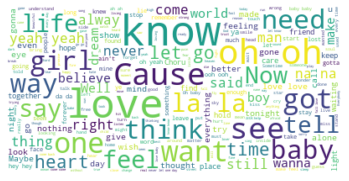

Word cloud of : Country


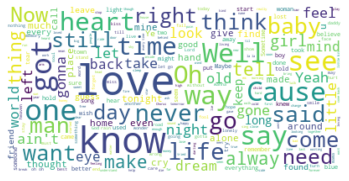

Word cloud of : Rock


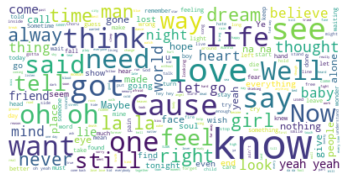

Word cloud of : Hip-Hop


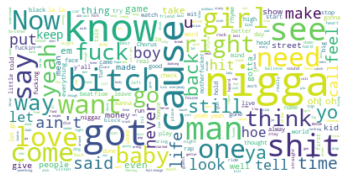

Word cloud of : Jazz


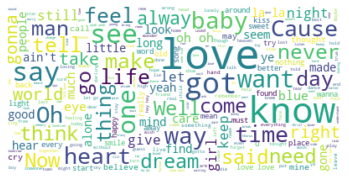

In [6]:
for value in genre_list:
    lyrics_df = df.loc[(df['genre'] == value )]
    lyrics = lyrics_df["lyrics"]
    all_lyrics = ""
    for x in lyrics:
        all_lyrics = all_lyrics+x
    max_words_len = get_max_length(lyrics_df)
    print("Word cloud of :", value)
    wordcloud = WordCloud(max_font_size=50, max_words=max_words_len, background_color="white").generate(all_lyrics) 
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()
    
    

# Data Analysis - Sentiment Analysis

In [7]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [8]:
#Create lists to store the different scores for each word
negative = []
neutral = []
positive = []
compound = []
#Initialize the model
sid = SentimentIntensityAnalyzer()
#Iterate for each row of lyrics and append the scores
for i in df.index:
    scores = sid.polarity_scores(df['lyrics'].iloc[i])
    negative.append(scores['neg'])
    neutral.append(scores['neu'])
    positive.append(scores['pos'])
    compound.append(scores['compound'])
#Create 4 columns to the main data frame  for each score
df['negative'] = negative
df['neutral'] = neutral
df['positive'] = positive
df['compound'] = compound
df.head()

,genre,lyrics,negative,neutral,positive,compound
0,Pop,Oh baby You know I'm gonna cut right chase Som...,0.088,0.577,0.335,0.9967
1,Pop,playin everything easy like seem sure still wa...,0.095,0.595,0.310,0.9807
2,Pop,If search For tenderness It hard find You love...,0.075,0.630,0.296,0.9833
3,Pop,Oh oh oh I oh oh oh I If I wrote book stand Th...,0.023,0.593,0.385,0.9992
4,Pop,Party people people party popping sitting arou...,0.094,0.848,0.058,-0.5859


In [9]:
df

,genre,lyrics,negative,neutral,positive,compound
0,Pop,Oh baby You know I'm gonna cut right chase Som...,0.088,0.577,0.335,0.9967
1,Pop,playin everything easy like seem sure still wa...,0.095,0.595,0.310,0.9807
2,Pop,If search For tenderness It hard find You love...,0.075,0.630,0.296,0.9833
3,Pop,Oh oh oh I oh oh oh I If I wrote book stand Th...,0.023,0.593,0.385,0.9992
4,Pop,Party people people party popping sitting arou...,0.094,0.848,0.058,-0.5859
...,...,...,...,...,...,...
185488,Country,I gotta say Boy couple date You're hand outrig...,0.028,0.838,0.135,0.9720
185489,Country,I helped find diamond ring You made try everyt...,0.245,0.480,0.275,0.5611
185490,Country,Look couple corner booth Looks lot like She's ...,0.046,0.767,0.187,0.9576
185491,Country,When I fly mortal earth And I'm measured depth...,0.073,0.605,0.322,0.9846


In [10]:
means_df = df.groupby(['genre']).mean()
means_df

,negative,neutral,positive,compound
genre,,,,
Country,0.109971,0.666931,0.223092,0.503343
Hip-Hop,0.152596,0.685029,0.162377,-0.032236
Jazz,0.095352,0.655508,0.249138,0.570685
Pop,0.106908,0.674011,0.219057,0.480918
Rock,0.134318,0.676311,0.187986,0.231792


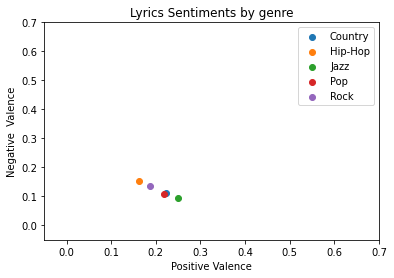

In [11]:
for name, group in means_df.groupby('genre'):
    plt.scatter(group['positive'],group['negative'],label=name)
    plt.legend()
plt.xlim([-0.05,0.7])
plt.ylim([-0.05,0.7])
plt.title("Lyrics Sentiments by genre")
plt.xlabel('Positive Valence')
plt.ylabel('Negative  Valence')
plt.show()